In [9]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.morningstar import Fundamentals as Fundamentals_m
from quantopian.pipeline.domain import US_EQUITIES
from quantopian.research import run_pipeline
from quantopian.research import prices
import alphalens as al
from alphalens.tears import create_returns_tear_sheet
from alphalens.tears import create_information_tear_sheet
from quantopian.pipeline.data import factset
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.data import Fundamentals
MAX_GROSS_LEVERAGE = 1.0
TOTAL_POSITIONS = 600

In [14]:
def make_pipeline():
    
    operating_cash_flow = Fundamentals_m.operating_cash_flow.latest # Winner Secure
    operating_cash_flow = operating_cash_flow.winsorize(min_percentile=0.05, max_percentile=0.95)
    universe = QTradableStocksUS()
    
    combined_factor = (
        operating_cash_flow.zscore()
    )

    longs = combined_factor.top(TOTAL_POSITIONS//2, mask=universe)
    shorts = combined_factor.bottom(TOTAL_POSITIONS//2, mask=universe)

    long_short_screen = (longs | shorts)

    # Create pipeline
    pipe = Pipeline(
        columns={
            'longs': longs,
            'shorts': shorts,
            'combined_factor': combined_factor
        },
        screen=long_short_screen
    )
    return pipe

Dropped 2.2% entries from factor data: 2.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


,1D,5D,10D
IC Mean,0.010,0.022,0.029
IC Std.,0.139,0.130,0.126
Risk-Adjusted IC,0.069,0.170,0.228
t-stat(IC),1.535,3.781,5.051
p-value(IC),0.125,0.000,0.000
IC Skew,0.034,-0.043,-0.054
IC Kurtosis,-0.003,-0.278,0.029


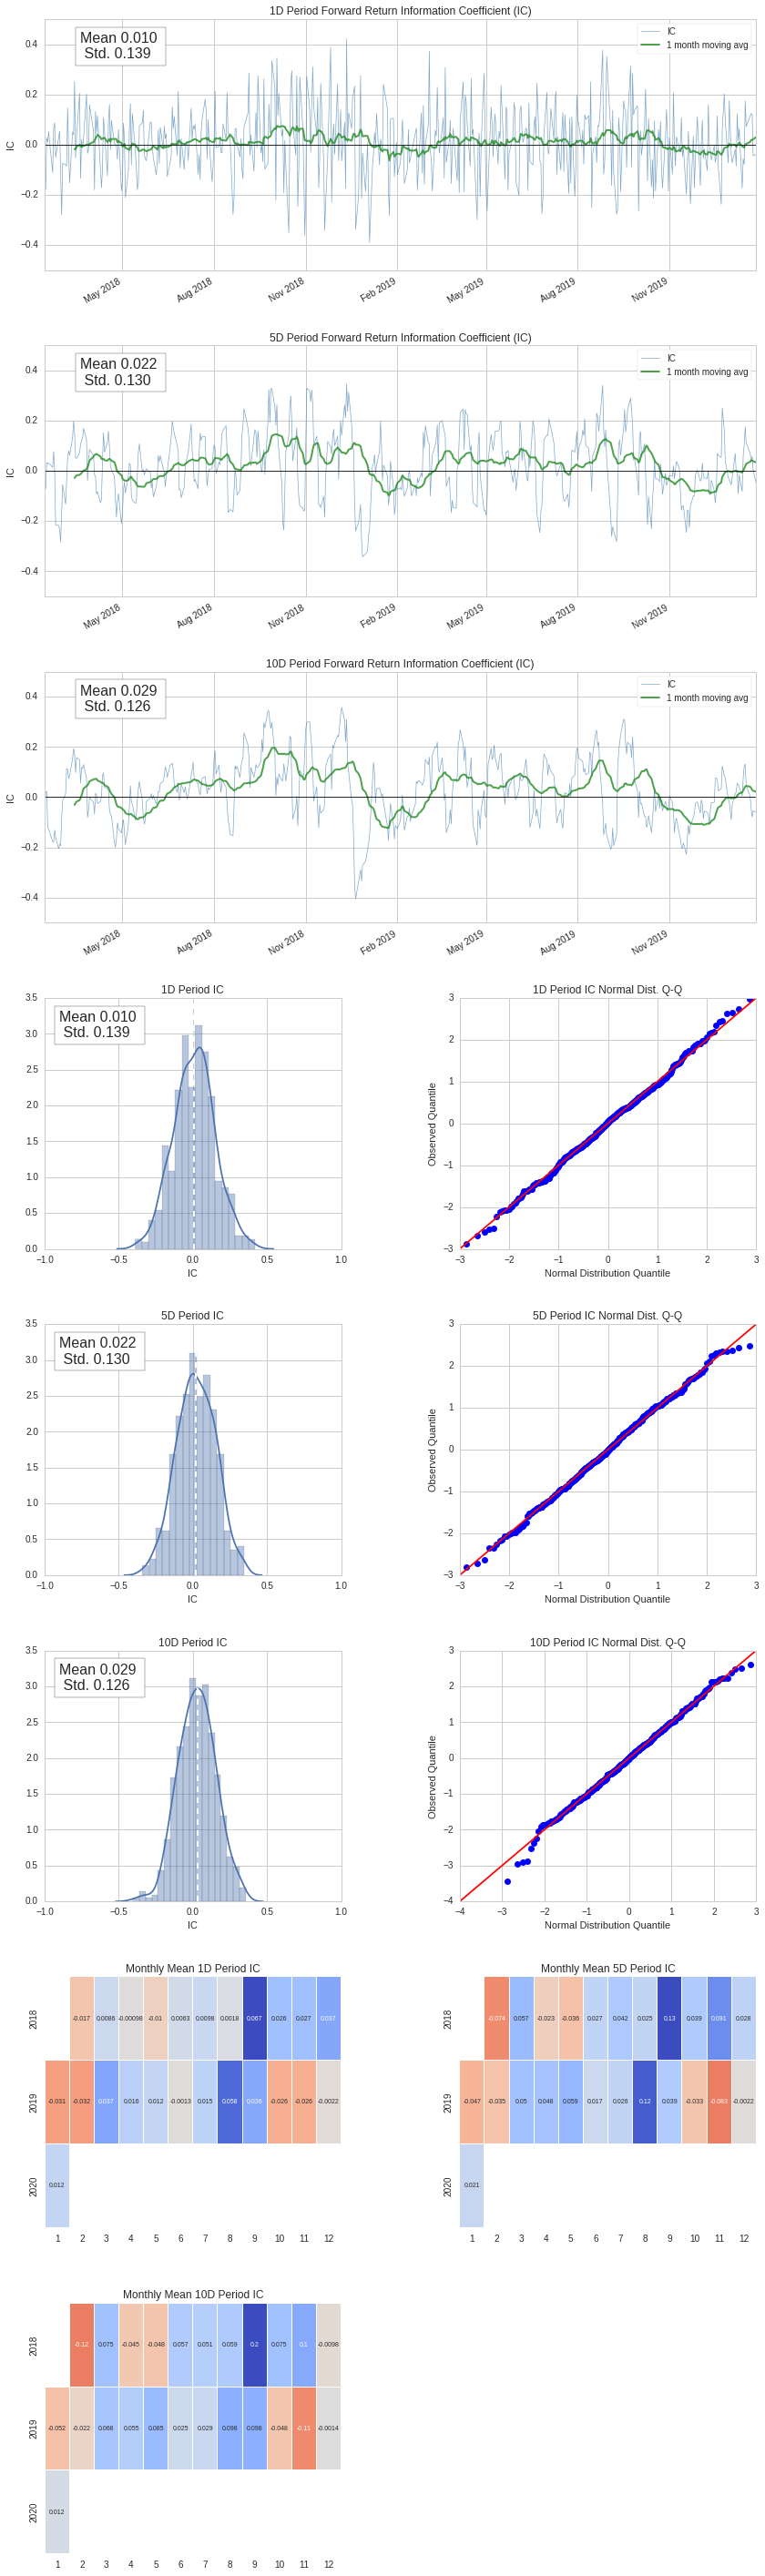

In [15]:
today = "2/11/2020"
two_years_before="2/11/2018"

pipeline_output = run_pipeline(
    make_pipeline(),
    start_date= two_years_before,
    end_date=today
)

asset_list = pipeline_output.index.levels[1].unique()
asset_prices = prices(
    asset_list,
    start=two_years_before,
    end=today
)
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=pipeline_output['combined_factor'],
    prices=asset_prices,
    quantiles=2,
    periods=(1,5,10),
)
create_information_tear_sheet(factor_data)

Returns Analysis


,1D,5D,10D
Ann. alpha,0.037,0.037,0.038
beta,-0.216,-0.232,-0.243
Mean Period Wise Return Top Quantile (bps),0.766,0.787,0.793
Mean Period Wise Return Bottom Quantile (bps),-0.769,-0.788,-0.793
Mean Period Wise Spread (bps),1.535,1.575,1.587


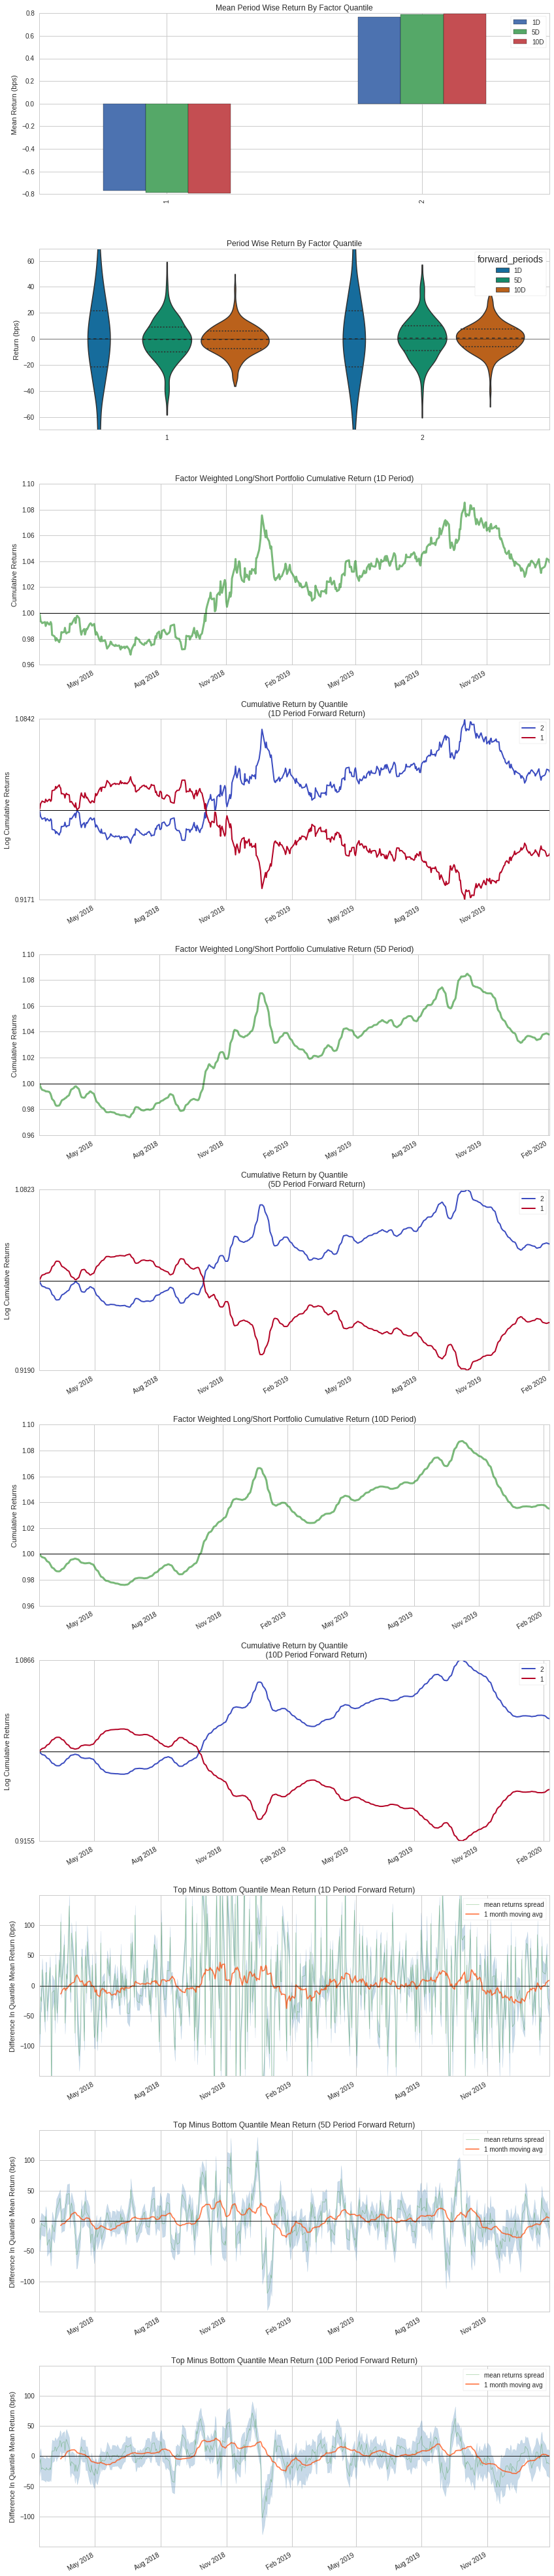

In [16]:
create_returns_tear_sheet(factor_data)